In [1]:
import numpy as np
import pandas as pd

import sklearn

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:
def generate_dataset(m, w1, w2, noise):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    X = np.empty((m, 3))
    X[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    X[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    X[:, 2] = X[:, 0] * w1 + X[:, 1] * w2 + noise * np.random.randn(m)
    
    return X

In [3]:
X = generate_dataset(m=60, w1=0.2, w2=0.3, noise=0.1)

(m, n) = X.shape

In [4]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_std = scaler.fit_transform(X)

In [5]:
X.shape

(60, 3)

In [6]:
# PCA using SVD

# SVD
U, s, Vt = np.linalg.svd(X_std)

# Principal Components
pc1 = Vt.T[:, 0]
pc2 = Vt.T[:, 1]

print(pc1)
print(pc2)

[-0.5683027  -0.49645819 -0.65617171]
[-0.60687624  0.79142033 -0.07317856]


In [7]:
S = np.zeros(X_std.shape)
S[:n, :n] = np.diag(s)

np.allclose(X_std, U.dot(S).dot(Vt)) # close enough?

True

In [8]:
# Projecting down to d dimensions; remember, PCA is a projection algorithm
W2 = Vt.T[:, :2]
X2D = X_std.dot(W2)
X2D.shape

X2D_np = X2D

In [9]:
# PCA using Scikit-learn
from sklearn.decomposition import PCA

pca = PCA(n_components=2)  # 2 principal components
X2D = pca.fit_transform(X_std)

In [10]:
X2D[:5]

array([[-0.02247107,  1.47563371],
       [ 0.00888448, -0.77727029],
       [-1.23675135, -0.69370885],
       [-1.53166934,  1.02330611],
       [-1.84346114,  0.54403971]])

In [11]:
X2D_np[:5]

array([[-0.02247107, -1.47563371],
       [ 0.00888448,  0.77727029],
       [-1.23675135,  0.69370885],
       [-1.53166934, -1.02330611],
       [-1.84346114, -0.54403971]])

In [12]:
# Principal Components
pca.components_

array([[-0.5683027 , -0.49645819, -0.65617171],
       [ 0.60687624, -0.79142033,  0.07317856]])

In [13]:
# Inverse PCA 
X3D_inv = pca.inverse_transform(X2D)
X3D_inv_np = X2D_np.dot(Vt[:2, :])

print(np.allclose(X3D_inv, X_std))  # True = close enough, False = information loss
print(np.allclose(X3D_inv_np, X_std))

# reconstruction error
reconstruction_error = np.mean(np.sum(np.square(X3D_inv - X_std), axis=1))  # MSE
reconstruction_error  # Since PCA is projection, there will almost certainly be some information loss

False
False


0.08823313570552424

In [14]:
# Explained Variance Ratio
print(np.square(s) / np.square(s).sum())  # (unit vector of s)^2
# Read after running:
# This is before the projection. The projection, which is onto the hyperplane that lies closest to the data, would have the least information loss 
# Notice that the dimension that was lost in the 3D -> 2D projection was the one that had the least explained variance ratio
# In other words, it is least responsible for the patterns within the data

# Sklearn
pca.explained_variance_ratio_  # BTW, the entries will always be in decreasing order

[0.7326926  0.23789636 0.02941105]


array([0.7326926 , 0.23789636])

In [15]:
# So how much variance did we lose by this projection exactly?
print(f"Variance Loss: {1 - pca.explained_variance_ratio_.sum()}")

Variance Loss: 0.029411045235174793


In [16]:
# How do I choose how many dimensions to keep?
# Let's use MNIST as an example

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

mnist = fetch_openml("mnist_784", version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

(X, y) = (mnist["data"], mnist["target"])

X_train, X_test, y_train, y_test = train_test_split(X, y)

pca_mnist = PCA()
pca_mnist.fit(X_train)

explained_variance_ratio_summation_series = np.cumsum(pca_mnist.explained_variance_ratio_)

retained_info = 0.95  # Only retain 95% of the information, so 5% info loss
last_pc_index = np.argmax(explained_variance_ratio_summation_series >= retained_info)
num_dimensions_to_keep = last_pc_index + 1  # arrays start at index 0

print(pca_mnist.explained_variance_ratio_[last_pc_index])

# Read after running:
# The rest of the components are responsible for only <= 0.045% of the variance each! We don't need 'em!
# We only need the 154 dimensions that matter!

num_dimensions_to_keep

0.00045824359556140374


153

Wow! These are diminishing gains!


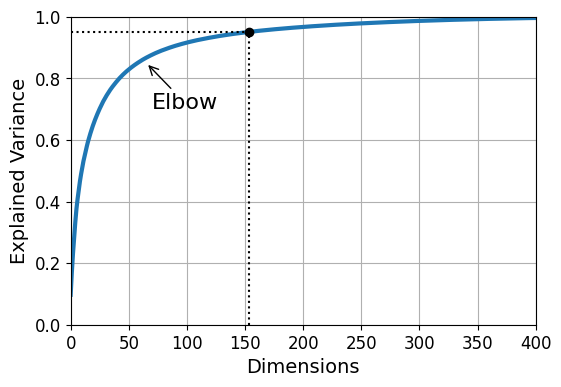

In [17]:
# Explained Variance as a function of the number of dimensions

print("Wow! These are diminishing gains!")

plt.figure(figsize=(6,4))
plt.plot(explained_variance_ratio_summation_series, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([num_dimensions_to_keep, num_dimensions_to_keep], [0, 0.95], "k:")
plt.plot([0, num_dimensions_to_keep], [0.95, 0.95], "k:")
plt.plot(num_dimensions_to_keep, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"), fontsize=16)
plt.grid(True)

plt.show()

In [18]:
# Now let's use it!
pca_mnist_optimal = PCA(n_components=retained_info)  # Yes, n_components can be a % of the dimensions of X
X_train_reduced = pca_mnist_optimal.fit_transform(X_train)

print(f"Principal Components: {pca_mnist_optimal.n_components_}")
np.sum(pca_mnist_optimal.explained_variance_ratio_)  # Read after running: Well would you look at that! We still have about 95% of the variance intact, but reduced 400 dimensions to 154!

Principal Components: 153


0.9500286783221289

Text(0.5, 1.0, 'Compressed (Recovered)')

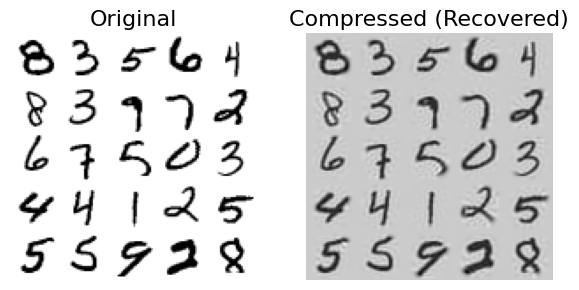

In [19]:
# Let's try to reverse that compression!
X_train_recovered = pca_mnist_optimal.inverse_transform(X_train_reduced)

def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)

plt.subplot(122)
plot_digits(X_train_recovered[::2100])
plt.title("Compressed (Recovered)", fontsize=16)

# Read after running:
# You can still recognize the digits, so not much was lost!

C:\Users\night\AppData\Local\Temp\ipykernel_107428\2231088804.py:55: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  ax.plot([X_std[i][0], X3D_inv[i][0]], [X_std[i][1], X3D_inv[i][1]], [X_std[i][2], X3D_inv[i][2]], "k-", color="#505050")
C:\Users\night\AppData\Local\Temp\ipykernel_107428\2231088804.py:14: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


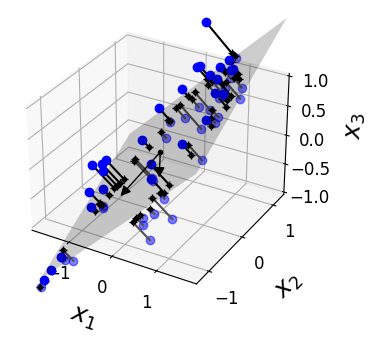

In [21]:
# PCA Projection Visualization

from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from mpl_toolkits.mplot3d import Axes3D

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)
    
    def do_3d_projection(self, renderer=None):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, self.axes.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))

        return np.min(zs)

axes = [-1.8, 1.8, -1.3, 1.3, -1.0, 1.0]

x1s = np.linspace(axes[0], axes[1], 10)
x2s = np.linspace(axes[2], axes[3], 10)
x1, x2 = np.meshgrid(x1s, x2s)

C = pca.components_
R = C.T.dot(C)
z = (R[0, 2] * x1 + R[1, 2] * x2) / (1 - R[2, 2])



fig = plt.figure(figsize=(6, 3.8))
ax = fig.add_subplot(111, projection='3d')

X3D_above = X_std[X_std[:, 2] > X3D_inv[:, 2]]
X3D_below = X_std[X_std[:, 2] <= X3D_inv[:, 2]]

ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "bo", alpha=0.5)

ax.plot_surface(x1, x2, z, alpha=0.2, color="k")
np.linalg.norm(C, axis=0)
ax.add_artist(Arrow3D([0, C[0, 0]],[0, C[0, 1]],[0, C[0, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.add_artist(Arrow3D([0, C[1, 0]],[0, C[1, 1]],[0, C[1, 2]], mutation_scale=15, lw=1, arrowstyle="-|>", color="k"))
ax.plot([0], [0], [0], "k.")

for i in range(m):
    if X_std[i, 2] > X3D_inv[i, 2]:
        ax.plot([X_std[i][0], X3D_inv[i][0]], [X_std[i][1], X3D_inv[i][1]], [X_std[i][2], X3D_inv[i][2]], "k-")
    else:
        ax.plot([X_std[i][0], X3D_inv[i][0]], [X_std[i][1], X3D_inv[i][1]], [X_std[i][2], X3D_inv[i][2]], "k-", color="#505050")
    
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k+")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "k.")
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "bo")
ax.set_xlabel("$x_1$", fontsize=18, labelpad=10)
ax.set_ylabel("$x_2$", fontsize=18, labelpad=10)
ax.set_zlabel("$x_3$", fontsize=18, labelpad=10)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

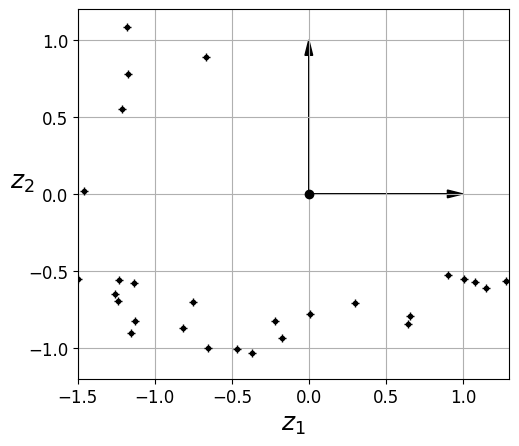

In [22]:
# PCA 3D -> 2D Projection Hyperplane Visualization
fig = plt.figure()
ax = fig.add_subplot(111, aspect='equal')

ax.plot(X2D[:, 0], X2D[:, 1], "k+")
ax.plot(X2D[:, 0], X2D[:, 1], "k.")
ax.plot([0], [0], "ko")
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True, head_length=0.1, fc='k', ec='k')
ax.set_xlabel("$z_1$", fontsize=18)
ax.set_ylabel("$z_2$", fontsize=18, rotation=0)
ax.axis([-1.5, 1.3, -1.2, 1.2])
ax.grid(True)

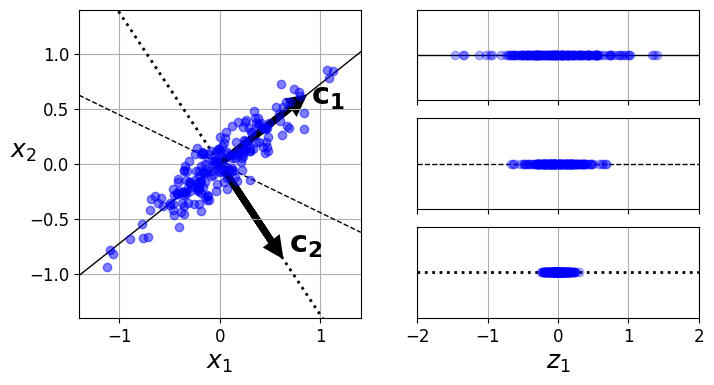

In [23]:
# PCA visualization 

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X = np.random.randn(m, 2) / 10
X = X.dot(np.array([[stretch, 0],[0, 1]])) # stretch
X = X.dot([[np.cos(angle), np.sin(angle)], [-np.sin(angle), np.cos(angle)]]) # rotate

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi/6), np.sin(angle - 2 * np.pi/6)])
u3 = np.array([np.cos(angle - np.pi/2), np.sin(angle - np.pi/2)])

X_proj1 = X.dot(u1.reshape(-1, 1))
X_proj2 = X.dot(u2.reshape(-1, 1))
X_proj3 = X.dot(u3.reshape(-1, 1))

plt.figure(figsize=(8,4))
plt.subplot2grid((3,2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4*u1[1]/u1[0], 1.4*u1[1]/u1[0]], "k-", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u2[1]/u2[0], 1.4*u2[1]/u2[0]], "k--", linewidth=1)
plt.plot([-1.4, 1.4], [-1.4*u3[1]/u3[0], 1.4*u3[1]/u3[0]], "k:", linewidth=2)
plt.plot(X[:, 0], X[:, 1], "bo", alpha=0.5)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=5, length_includes_head=True, head_length=0.1, fc='k', ec='k')
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", fontsize=22)
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", fontsize=22)
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot2grid((3,2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=1)
plt.plot(X_proj1[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=1)
plt.plot(X_proj2[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid(True)

plt.subplot2grid((3,2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "bo", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

In [24]:
# Randomized PCA

# FAST stochastic algorithm
# m = training examples, n = features (dimensionality of X[i]), d = dimensionality of dimensionality-reduced X[i]
# Randomized PCA Time Complexity: O(m x d^2) + O(d^3)
# Regular SVD PCA Time Complexity: O(m x n^2) + O(n^3)
# MUCH FASTER WHEN d << n

# By default in sklearn, svd_solver="auto" => selectively chooses between full SVD approach and randomized
# To force sklearn to always use full SVD approach, svd_solver="full"
# approximates the first num_dimensions_to_keep PC
rnd_pca = PCA(n_components=num_dimensions_to_keep, svd_solver="randomized")
X_train_reduced_rnd = rnd_pca.fit_transform(X_train)

Fitting....................................................................................................

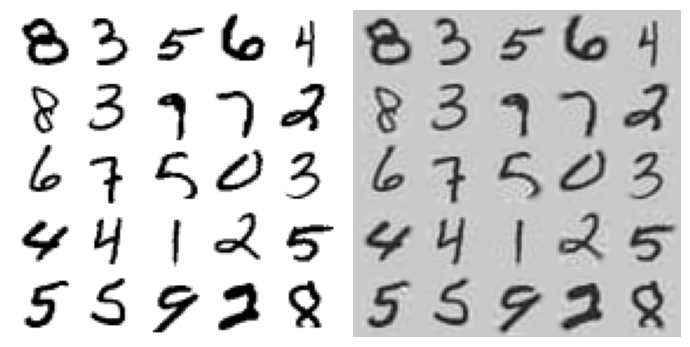

In [25]:
# Incremental PCA
# Great for online learning or if the memory requirements are too high to load the data

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=num_dimensions_to_keep)

print("Fitting", end="") # no \n at the end
for X_batch in np.array_split(X_train, n_batches):
    print(".", end="") # loading...
    inc_pca.partial_fit(X_batch)

X_train_reduced_inc = inc_pca.fit_transform(X_train)
X_train_recovered_inc = inc_pca.inverse_transform(X_train_reduced_inc)

# Visualize it now
plt.figure(figsize=(7, 4))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.subplot(122)
plot_digits(X_train_recovered_inc[::2100])
plt.tight_layout()

In [26]:
# Compare results: regular PCA vs Incremental PCA
print(np.allclose(pca_mnist_optimal.mean_, inc_pca.mean_))  # Post-run: They have the same means, good
print(np.allclose(X_train_reduced, X_train_reduced_inc))    # Post-run: However, Incremental PCA is just an approximation

True
False


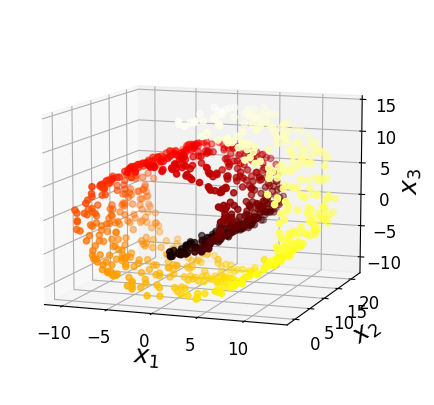

In [27]:
# Let's get the swiss roll now!
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

# Now visualize it
axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=t, cmap=plt.cm.hot)
ax.view_init(10, -70)
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

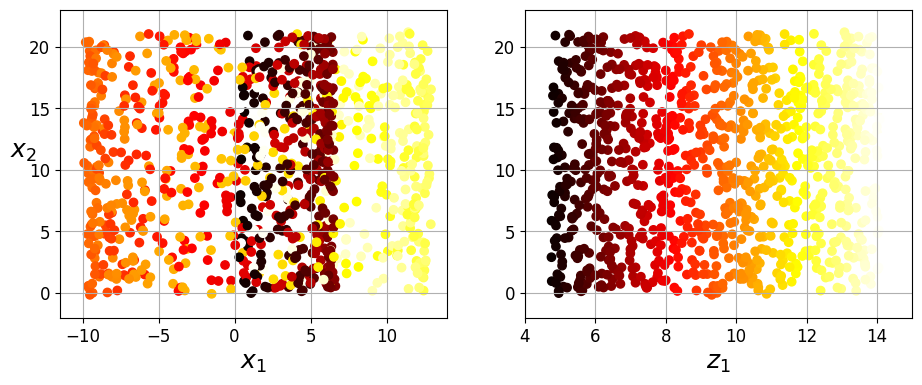

In [28]:
# Visualization: Squashing (left) vs. Unrolling (right)
# If we used PCA or some kind of projection, it is likely to squash
# We want to unroll it using Manifold Learning

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$x_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.grid(True)

plt.show()

Sometimes, it is that complicated bro


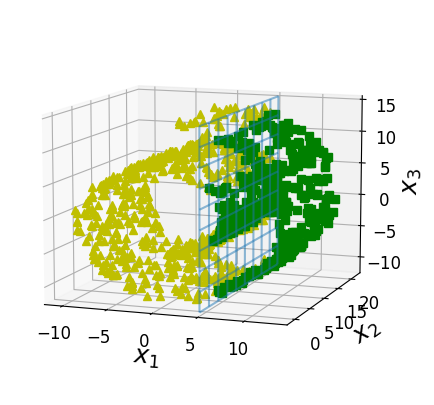

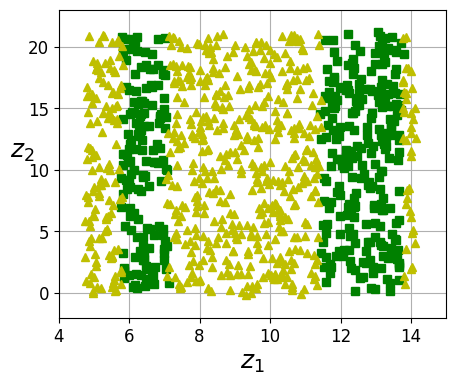

But other times, it isn't


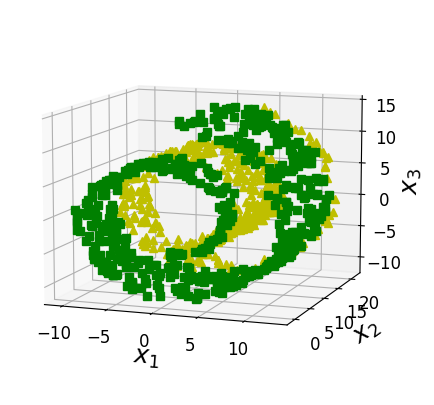

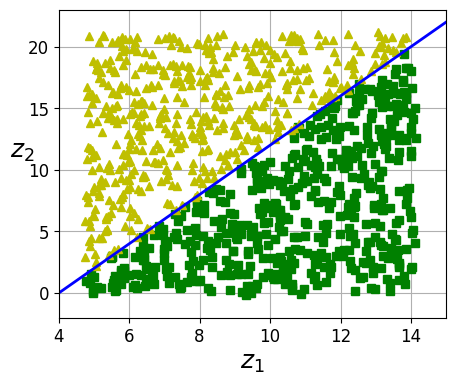

In [29]:
from matplotlib import gridspec

# The Manifold Hypothesis states: "it ain't that complicated bro"
# However, this is not always true
print("Sometimes, it is that complicated bro")

axes = [-11.5, 14, -2, 23, -12, 15]

x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = X[:, 0] > 5
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

print("But other times, it isn't")

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111, projection='3d')

positive_class = 2 * (t[:] - 4) > X[:, 1]
X_pos = X[positive_class]
X_neg = X[~positive_class]
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.set_xlabel("$x_1$", fontsize=18)
ax.set_ylabel("$x_2$", fontsize=18)
ax.set_zlabel("$x_3$", fontsize=18)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])

plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(111)

plt.plot(t[positive_class], X[positive_class, 1], "gs")
plt.plot(t[~positive_class], X[~positive_class, 1], "y^")
plt.plot([4, 15], [0, 22], "b-", linewidth=2)
plt.axis([4, 15, axes[2], axes[3]])
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

plt.show()

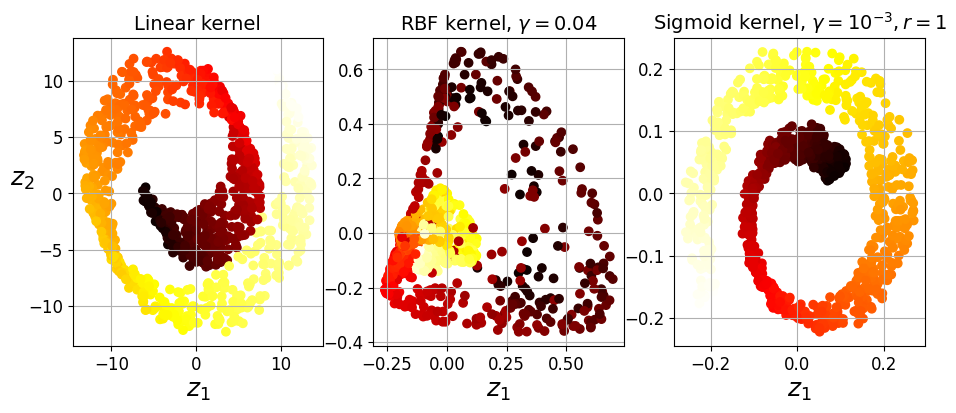

In [30]:
# we can still use PCA on this swiss roll, but Kernel PCA is THE way to go here

# Kernel PCA
from sklearn.decomposition import KernelPCA

# 3D -> 2D projection
linear_pca = KernelPCA(n_components=2, kernel="linear")                         # Bruh moment
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.0433)                 # Best way to go
sigmoid_pca = KernelPCA(n_components=2, kernel="sigmoid", gamma=0.001, coef0=1) # uhh

X_swiss_reduced_rbf = rbf_pca.fit_transform(X)

# Now visualize what kernel pca can do
plt.figure(figsize=(11, 4))
for subplot, pca, title in ((131, linear_pca, "Linear kernel"), (132, rbf_pca, "RBF kernel, $\gamma=0.04$"), (133, sigmoid_pca, "Sigmoid kernel, $\gamma=10^{-3}, r=1$")):
    X_swiss_reduced_kernel = pca.fit_transform(X)
    if subplot == 132:
        X_swiss_reduced_rbf = X_swiss_reduced_kernel
    
    plt.subplot(subplot)
    plt.title(title, fontsize=14)
    plt.scatter(X_swiss_reduced_kernel[:, 0], X_swiss_reduced_kernel[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$", fontsize=18)
    if subplot == 131:
        plt.ylabel("$z_2$", fontsize=18, rotation=0)
    plt.grid(True)

plt.show()

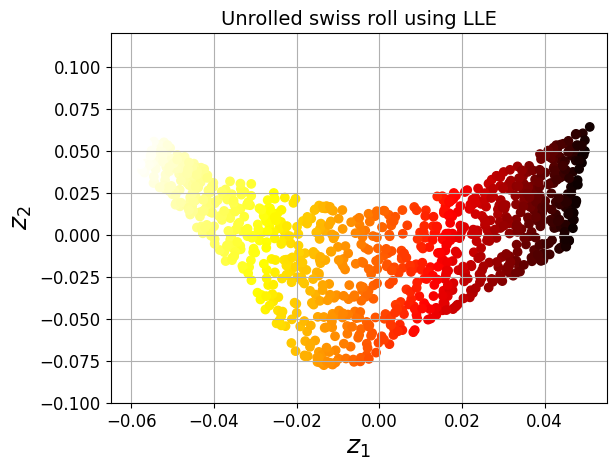

In [33]:
# Manifold Learning: LLE
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_swiss_reduced_lle = lle.fit_transform(X)

# Now visualize it
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_swiss_reduced_lle[:, 0], X_swiss_reduced_lle[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()